Created by: Eve Marenghi, November 2018

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

# data acquisition

In [1]:
# import packages 
import statsmodels.formula.api as smf
import zipfile as zipfile
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
# download the energy consumption data for the city of NY 
# from https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energy_consumption.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  3116k      0 --:--:--  0:00:01 --:--:-- 3114k


In [3]:
# move to PUIdata folder 
!mv energy_consumption.csv $PUIDATA

In [4]:
# download the pluto data for Manhattan from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
!curl https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip > mn_pluto.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  26.5M      0 --:--:-- --:--:-- --:--:-- 26.6M


In [5]:
# move to PUIdata folder
!mv mn_pluto.zip $PUIDATA

In [6]:
# unzip Mn pluto zipfile 
mn_pluto = zipfile.ZipFile(os.getenv("PUIDATA") + "/mn_pluto.zip" , 'r')
mn_pluto.extractall(os.getenv("PUIDATA"))
mn_pluto.close()

In [7]:
# load the building size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + "/energy_consumption.csv")

bsize = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## exploring the data

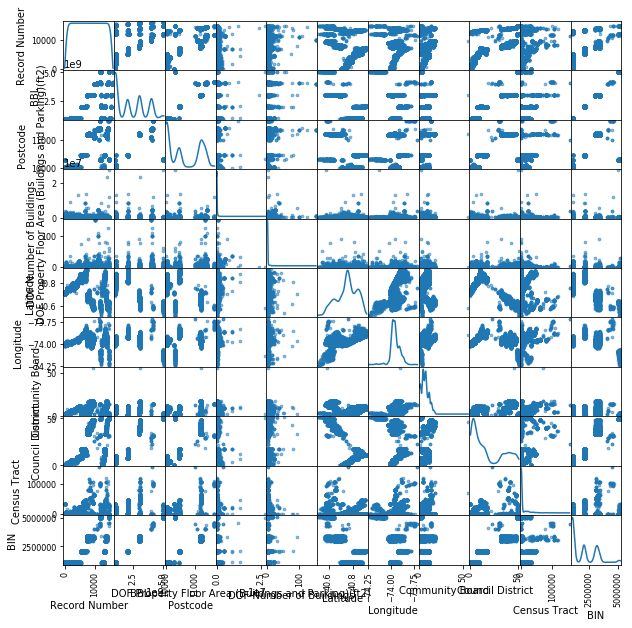

In [8]:
# plot a scatter matrix of the nrg dataset 
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: Scatter matrix plotting all variables in the nrg dataframe against all other variables. A scatter matrix is a plot of all variables in the data against all other variables. Each pair of variables is a subplot in the plot matrix. The diagonal line then is a KDE, which is basically a smooth histogram. Notably, I can only plot columns with numeric values. I am unable to plot columns such as Site EUI(kBtu/ft2) because that column contains datatypes that pandas does not know how to convert. Also, the scatter matrix is too large and complicated. Too many variables are being compared against each other, and I cannot read or interpret the axes. I have to clean the data and do some conversions in order to plot an interpretable scatter matrix.

## data cleaning and aggregation 

In [9]:
# keep only columns we need for the energy dataset
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [10]:
# keep only the columns we need for the pluto dataset 
bsize = bsize[['BBL', 'UnitsTotal', 'UnitsRes', 'YearBuilt', 'geometry']]

In [11]:
# check contents of new nrg
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [12]:
# check contents of new bsize
bsize.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.015450e+09,18,16,1920,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,1.016800e+09,10,10,1910,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,1.011970e+09,26,26,1900,"POLYGON ((992273.6849975586 224863.4904174805,..."


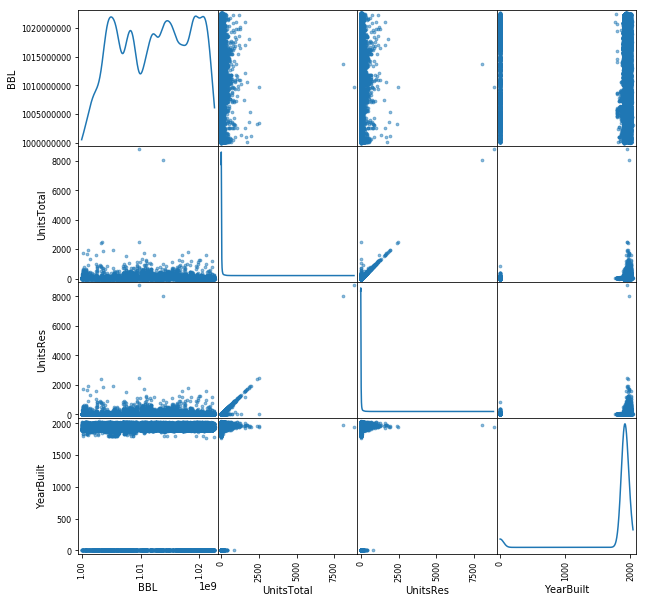

In [13]:
# create a scatter matrix of building dataset 
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: Scatter matrix plotting all variables in the bsize dataframe against all other variables. A scatter matrix is a plot of all variables in the data against all other variables. Each pair of variables is a subplot in the plot matrix. The diagonal line then is a KDE, which is basically a smooth histogram. There is a positive linear correlation between UnitsRes and UnitsTotal, which is obvious. There is no clear correlation between other variables in the dataframe. The YearBuilt column has 0 values which need to be removed because it doesn't make sense that a unit was built in year 0. UnitsTotal column also has 0 values which can be removed because we're not interested in analyzing lots with 0 units.

## convert relevant columns to numeric values and throw away spurious entries

In [14]:
# convert relevant columns to numeric data types coercing errors where necessary
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property ' + \
                                            'Floor Area (Building(s)) (ft²)'], errors='coerce')

bsize.BBL = pd.to_numeric(bsize.BBL, errors='coerce')
bsize.UnitsTotal = pd.to_numeric(bsize.UnitsTotal, errors='coerce')
bsize.UnitsRes = pd.to_numeric(bsize.UnitsRes, errors='coerce')
bsize.YearBuilt = pd.to_numeric(bsize.YearBuilt, errors='coerce')

In [15]:
# check numeric conversions
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10], bsize.UnitsTotal.astype(float)[:10], \
                            bsize.UnitsRes.astype(float)[:10], bsize.YearBuilt.astype(float)[:10], \
                            nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64, 0    18.0
 1    50.0
 2    10.0
 3    32.0
 4    26.0
 5     3.0
 6     8.0
 7     2.0
 8    30.0
 9    10.0
 Name: UnitsTotal, dtype: float64, 0    16.0
 1    50.0
 2    10.0
 3    29.0
 4    26.0
 5     2.0
 6     0.0
 7     0.0
 8    30.0
 9    10.0
 Name: UnitsRes, dtype: float64, 0    1920.0
 1    1914.0
 2    1910.0
 3    1928.0
 4    1900.0
 5    1910.0
 6    1920.0
 7    1915.0
 8    1915.0
 9    1900.0
 Name: YearBuilt, dtype: float64, 0    918919.0
 1         NaN
 2     64200.0
 3         NaN
 4     50000.0
 5     61800.0
 6    102198.0
 7     46620.0
 8         NaN
 9     54029.0
 Name: Reported Property Floor Area (Building(s)) (f

No errors were returned through this check of numeric conversions, indicating that the conversion to numerics were completed successfully.

In [16]:
# check conversion worked - number of missing energy observations
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [17]:
# check conversion worked - fraction of missing energy observations
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


In [18]:
# drop na values
nrg.dropna(inplace=True)
bsize.dropna(inplace=True)

In [19]:
# check how many rows have UnitsTotal = 0 to determine if I can drop these rows 
bsize.groupby('UnitsTotal').count()

,BBL,UnitsRes,YearBuilt,geometry
UnitsTotal,,,,
0,2426,2426,2426,2426
1,5616,5616,5616,5616
2,3464,3464,3464,3464
3,2615,2615,2615,2615
4,2301,2301,2301,2301
5,1783,1783,1783,1783
6,1296,1296,1296,1296
7,1211,1211,1211,1211
8,1336,1336,1336,1336


In [20]:
# check total rows in the bsize dataframe 
bsize.shape

(42556, 5)

In [21]:
# calculate fraction of rows with UnitsTotal = 0 
(2426 / 42556) * 100

5.700723752232353

In [22]:
# check how many rows have Site EUI(kBtu/ft2) = 0 to determine if I can drop these rows 
nrg.groupby('Site EUI(kBtu/ft2)').count()

,BBL,Reported Property Floor Area (Building(s)) (ft²)
Site EUI(kBtu/ft2),,
0.0,14,14
0.1,5,5
0.2,3,3
0.3,4,4
0.4,1,1
0.5,1,1
0.6,1,1
0.8,2,2
0.9,5,5


In [23]:
# check total rows in the nrg dataframe 
nrg.shape

(11457, 3)

In [24]:
# calculate fraction of rows with Site EUI(kBtu/ft2) = 0 
(14 / 11457) * 100

0.12219603735707427

In [25]:
# drop values where UnitsRes = 0 and Site EUI(kBtu/ft2) = 0 
bsize_no0 = bsize.drop(bsize[(bsize.UnitsTotal == 0)].index)
nrg_no0 = nrg.drop(nrg[(nrg['Site EUI(kBtu/ft2)'] == 0)].index)

I'm dropping rows where UnitsTotal = 0 in the bsize dataframe and where Site EUI(kBtu/ft2) = 0 in the nrg dataframe because it doesn't make sense for my analysis to analyze lots with 0 units or 0 energy consumed since I want to use building occupancy to predict energy consumption. Lots with 0 units represent 5% of the total bsize dataset. Lots with 0 energy consumed represent 0.1% of the total nrg dataset.

 ## merge the two datasets

In [26]:
#merge in a geodataframe for mapping and in a regular DF for analysis on BBL
bblnrgdataGPD = bsize_no0.merge(nrg_no0, left_on='BBL', right_on='BBL', how='inner')
bblnrgdata = nrg_no0.merge(bsize_no0, left_on='BBL', right_on='BBL', how='inner')

In [27]:
# check contents of DF 
bblnrgdata.head(2)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.013110e+09,125.4,330000.0,56,0,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
1,1.010140e+09,154.9,841709.0,2,0,1999,"POLYGON ((987726.6307983398 214846.9885864258,..."


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [28]:
# calculate logunits and lognrg for plotting the df 
bblnrgdataGPD['logunits'] = np.log10(bblnrgdataGPD['UnitsTotal'])
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'])

In [29]:
bblnrgdataGPD.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logunits,lognrg
0,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,1.698970,1.836957
1,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,1.505150,1.941511
2,1.021740e+09,72,72,1923,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,1.857332,2.147367
3,1.008830e+09,108,107,1931,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,2.033424,1.984527
4,1.008570e+09,138,134,1910,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,2.139879,1.561101


I converted UnitsTotal and energy consumed to log10 scale because the data is distributed very “unevenly”. In the natural scale, most observations have low energy and low number of floors. There are a few values in the scale of 10^6 or 10^7 and a few as high as 10^9. In the log10 scale, this becomes a 6 to 9 range. Similar logic applies for the floors, though less so with number of units between 10 and 1000. 

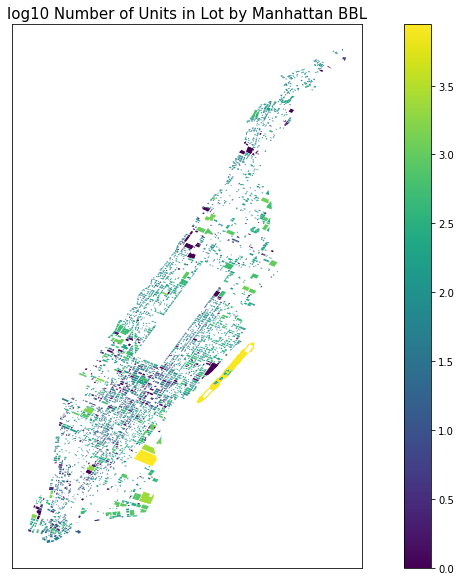

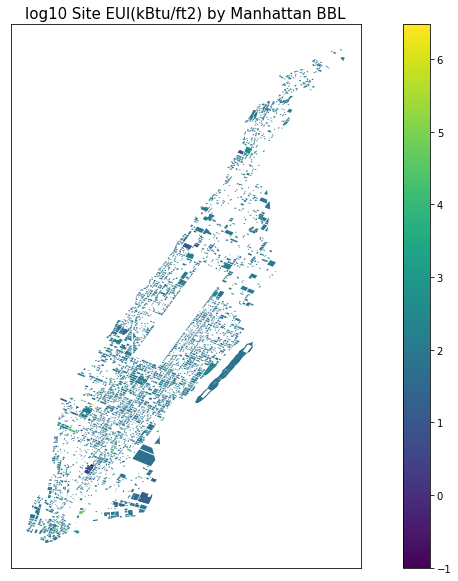

In [30]:
# plot a chropleth of log10(number of units) and log10(energy consumed)
f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='logunits',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("log10 Number of Units in Lot by Manhattan BBL", fontsize=15)
ax.set_aspect(.75)

f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='lognrg',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("log10 Site EUI(kBtu/ft2) by Manhattan BBL", fontsize=15)
ax.set_aspect(.75)

Figure 3: The top plot is a choropleth of log10 Number of units in lot by Manhattan Borough Block Lot and the bottom plot is a choropleth of log10 Site EUI(kBtu/ft2) by Manhattan Borough Block Lot. Yellow/green lots indicate higher number of units or higher energy for the two plots respectively. Blue/purple lots indicate lower number of units or lower energy for the two plots respectively. I converted UnitsTotal and energy consumed to log10 scale because the data is distributed very “unevenly”. In the natural scale, most observations have low energy and low number of units. For energy, there are a few values in the scale of 10^6 or 10^7 and a few as high as 10^9. In the log10 scale, this becomes a 6 to 9 range. Similar logic applies for the number of units, though less so with number of units between 1 and 1000. Interestingly, in the building units choropleth, I can see that Roosevelt Island has one of the lots with the highest number of units. This might be because Roosevelt Island has a small population and is only a few BBLs. The Con Edison power plant in the East Village of Manhattan has a high number of units (this is indicated by the single yellow BBL in the units choropleth). In the energy choropleth, I don't see any outliers that stand out. The shade of the choropleth is relatively uniform, with most BBLs in the 1 to 3 range for energy consumption. 

# feature engineering

Text(0,0.5,'Number of Units in Building')

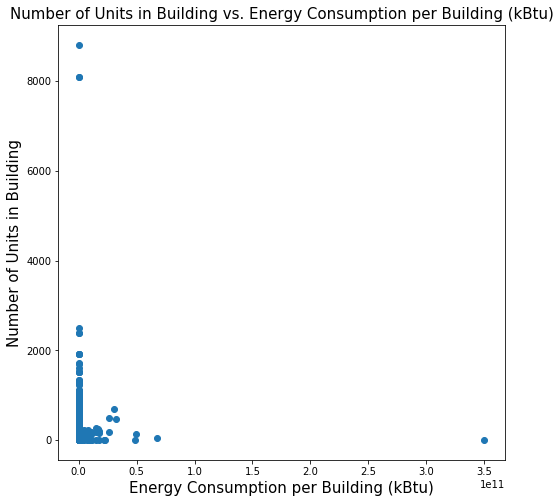

In [31]:
## multiply area by energy/area to get total energy per building and plot 
figure = plt.figure(figsize=(8,8))
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
plt.scatter(bblnrgdata.nrg, bblnrgdata.UnitsTotal)
plt.title('Number of Units in Building vs. Energy Consumption per Building (kBtu)', fontsize=15)
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=15)
plt.ylabel('Number of Units in Building', fontsize=15)

In [32]:
# check max and min building energy values 
print('minimum building energy value', bblnrgdata['nrg'].min())
print('maximum building energy value', bblnrgdata['nrg'].max())

minimum building energy value 5344.0
maximum building energy value 350145188000.0


(0.0, 100000000000.0)

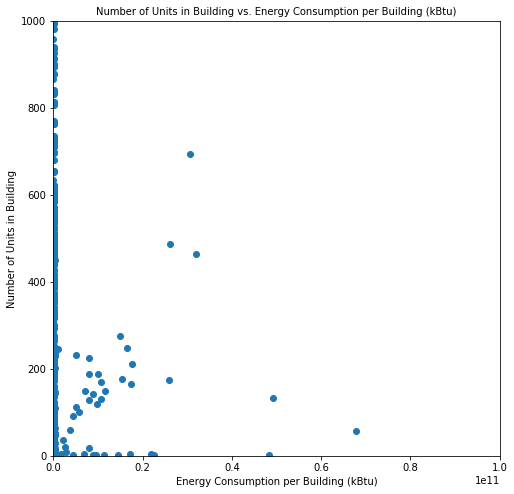

In [33]:
# create another plot removing outliers and zooming in on the data 
figure = plt.figure(figsize=(8,8))
plt.scatter(bblnrgdata.nrg, bblnrgdata.UnitsTotal)
plt.title('Number of Units in Building vs. Energy Consumption per Building (kBtu)', fontsize=10)
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=10)
plt.ylabel('Number of Units in Building', fontsize=10)
plt.ylim(0.0, 1000)
plt.xlim(0.0, 1e11)

Figure 4: Scatterplot of number of units in building vs. energy consumption per building. The first plot above is difficult to interpret because I'm unable to see most points due to outliers in the plot. The second plot above is zoomed in with x axis limits (0, 1e11) and y axis limits (0, 1000). I see that there are a lot of points along the y axis with very low levels of energy consumption. There appears to be a positive linear relationship between number of units in building and energy consumption per building for the group of points in the lower left area of the scatterplot. 

# Plot both NRG vs Units total and Units total vs NRG, both in log space

In [34]:
# cut the data to remove datapoints 
# limit energy to between (1000,1e10) as instructed by FB
# limit units to between (1,1000) as instructed by FB
bblnrgdata_trunc = bblnrgdata.drop(bblnrgdata[(bblnrgdata.nrg < 1000) & (bblnrgdata.nrg > 1e10) &
                                             (bblnrgdata.UnitsTotal < 1) & (bblnrgdata.UnitsTotal > 1000)].index)

Text(0,0.5,'log10 Energy Consumption per Building (kBtu)')

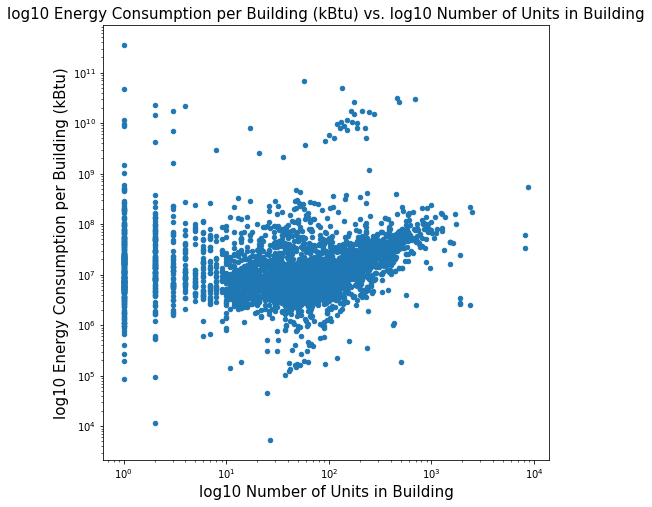

In [35]:
# plot the data 
plt.figure(figsize=(10,10))
bblnrgdata_trunc.plot(kind='scatter', x='UnitsTotal', y='nrg', loglog=True, figsize=(8,8))
plt.title('log10 Energy Consumption per Building (kBtu) vs. log10 Number of Units in Building', fontsize=15)
plt.xlabel('log10 Number of Units in Building', fontsize=15)
plt.ylabel('log10 Energy Consumption per Building (kBtu)', fontsize=15)

Figure 5: Log10 Energy Consumption per Building (kBtu) vs. Log10 Number of Units in Building. I converted to log10 scale to adjust orders of magnitude to more interpretable values. Here number of units in building is the independent variable and energy consumption per building is the dependent variable, which makes sense because energy consumption is dependent on the number of units in the building. The data looks like it could be fit by a linear or quadratic model. Based on the shape of the data, a quadratic model would probably be a better fit.

Text(0,0.5,'log10 Number of Units in Building')

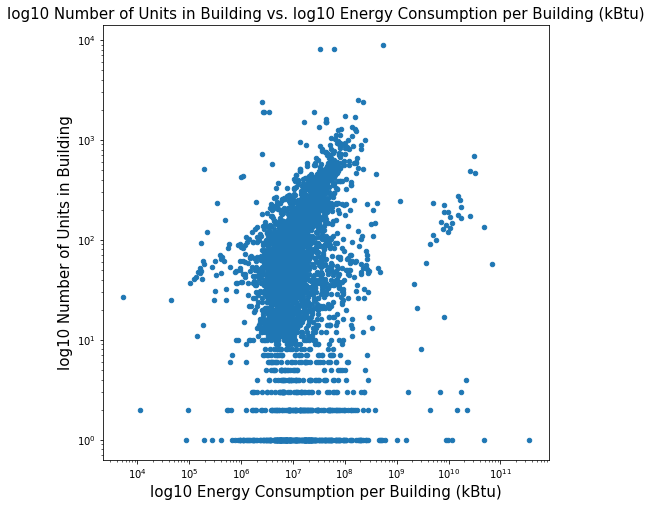

In [36]:
# plot the data 
plt.figure(figsize=(10,10))
bblnrgdata_trunc.plot(kind='scatter', x='nrg', y='UnitsTotal', loglog=True, figsize=(8,8))
plt.title('log10 Number of Units in Building vs. log10 Energy Consumption per Building (kBtu)', 
          fontsize=15)
plt.xlabel('log10 Energy Consumption per Building (kBtu)', fontsize=15)
plt.ylabel('log10 Number of Units in Building', fontsize=15)

Figure 6: Log10 Number of Units in Building vs. Log10 Energy Consumption per Building (kBtu). I converted to log10 scale to adjust orders of magnitude to more interpretable values. Here number of units in building is the dependent variable and energy consumption per building is the independent variable, which doesn't make sense because number of units in the building is not dependent on energy consumption. 

# Fit the data with a line in log space

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**: Number of units causes energy consumption. Therefore, number of units is the independent variable and energy consumption is the dependent variable.

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [37]:
# add columns for lognrg and logunits 
bblnrgdata_trunc['lognrg'] = np.log10(bblnrgdata_trunc.nrg)
bblnrgdata_trunc['logunits'] = np.log10(bblnrgdata_trunc.UnitsTotal)

In [38]:
# fit a linear model to the data 
u_vs_e = smf.ols(formula='logunits ~  lognrg', data=bblnrgdata_trunc).fit()
u_vs_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     89.74
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           4.09e-21
Time:                        19:41:47   Log-Likelihood:                -5029.3
No. Observations:                4977   AIC:                         1.006e+04
Df Residuals:                    4975   BIC:                         1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4857      0.127      3.827      0.000         0.237     0.734
lognrg         0.1699      0.018      9.473      0.000         0.135     0.205
==============================================================================
Omnibus:                      829.044   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1330.307
Skew:                          -1.142   Prob(JB):                    1.34e-289
Kurtosis:                       4.093   Cond. No.                         97.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'log10 Number of Units in Building')

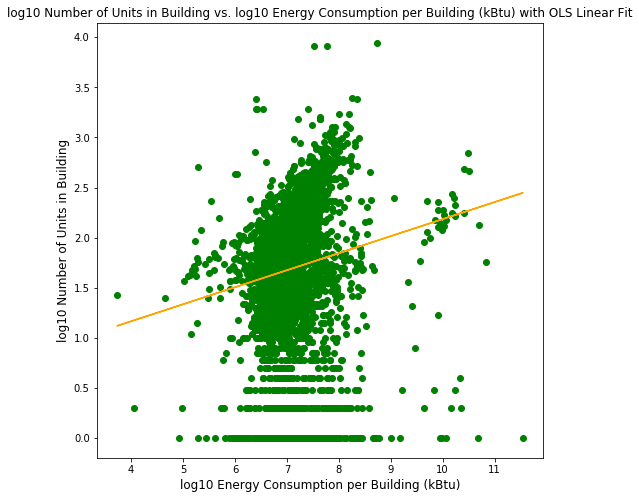

In [39]:
# plot the data and the model 
plt.figure(figsize=(8,8))
plt.plot(bblnrgdata_trunc['lognrg'], bblnrgdata_trunc['logunits'], 'go')
plt.plot(bblnrgdata_trunc['lognrg'], u_vs_e.predict(bblnrgdata_trunc),'-', color='orange')
plt.title('log10 Number of Units in Building vs. log10 Energy Consumption per Building (kBtu) with OLS Linear Fit', 
          fontsize=12)
plt.xlabel('log10 Energy Consumption per Building (kBtu)', fontsize=12)
plt.ylabel('log10 Number of Units in Building', fontsize=12)

Figure 7: Number of units in building vs. energy consumption per building (kBtu) in log10 scale plotted with an OLS linear model fit to the data. R-squared is 0.018 and log-likelihood is -5029.3 for the model. R-squared is close to 0 which indicates that the model does not fit the data very well. Log-likelihood is a negative value that is large in magnitude which also indicates that the model does not fit the data very well.

### Energy against Units

In [40]:
# fit a linear model to the data 
e_vs_u = smf.ols(formula='lognrg ~  logunits', data=bblnrgdata_trunc).fit()
e_vs_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     89.74
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           4.09e-21
Time:                        19:41:47   Log-Likelihood:                -3815.3
No. Observations:                4977   AIC:                             7635.
Df Residuals:                    4975   BIC:                             7648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.8814      0.020    344.710      0.000         6.842     6.920
logunits       0.1043      0.011      9.473      0.000         0.083     0.126
==============================================================================
Omnibus:                     2249.504   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28357.494
Skew:                           1.821   Prob(JB):                         0.00
Kurtosis:                      14.113   Cond. No.                         6.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'log10 Energy Consumption per Building (kBtu) vs. log10 Number of Units in Building with OLS Linear Fit')

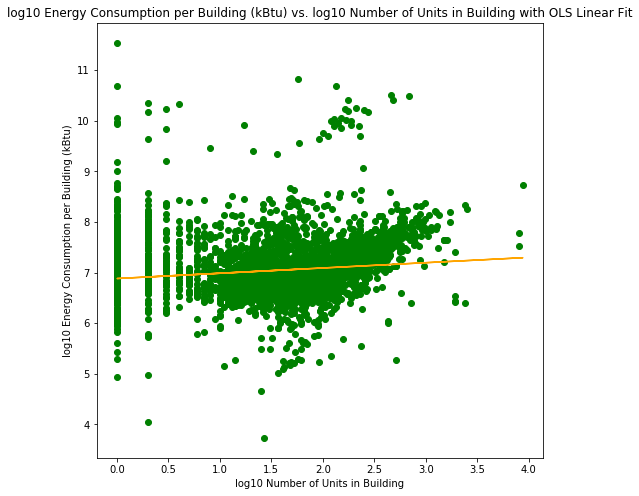

In [41]:
# plot the data and the model 
plt.figure(figsize=(8,8))
plt.plot(bblnrgdata_trunc['logunits'],bblnrgdata_trunc['lognrg'],'go')
plt.plot(bblnrgdata_trunc['logunits'], e_vs_u.predict(bblnrgdata_trunc),'-', color='orange')
plt.xlabel('log10 Number of Units in Building')
plt.ylabel('log10 Energy Consumption per Building (kBtu)')
plt.title('log10 Energy Consumption per Building (kBtu) vs. log10 Number of Units in Building with OLS Linear Fit', 
          fontsize=12)

Figure 8: Energy consumption per building (kBtu) vs. Number of units in building in log10 scale plotted with an OLS linear model fit to the data. R-squared is 0.018 and log-likelihood is -3815.3 for the model. R-squared is close to 0 which indicates that the model does not fit the data very well. Log-likelihood is a negative value that is smaller in magnitude then the log-likehood for the first model (units vs. energy). I want to maximize the likelihood (minimize the negative log-likelihood) to fit the data as best as possible, so the second model (with number of units the independent variable) is better than the first model. It's interesting that the r-squared values for both models is exactly the same (0.018). 

# Second degree polynomial fit

In [42]:
# units as independent and energy as dependent
# create a new feature for x^2
bblnrgdata_trunc['logunits_sq'] = bblnrgdata_trunc['logunits']**2

In [43]:
# fit a model to the data 
OLS_2nd_deg = smf.ols(formula='lognrg ~ logunits_sq + logunits',data=bblnrgdata_trunc).fit()
OLS_2nd_deg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     423.4
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          1.59e-170
Time:                        19:41:48   Log-Likelihood:                -3468.5
No. Observations:                4977   AIC:                             6943.
Df Residuals:                    4974   BIC:                             6963.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       7.2788      0.024    307.815      0.000         7.232     7.325
logunits_sq     0.3025      0.011     27.270      0.000         0.281     0.324
logunits       -0.7220      0.032    -22.566      0.000        -0.785    -0.659
==============================================================================
Omnibus:                     2329.894   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39136.882
Skew:                           1.811   Prob(JB):                         0.00
Kurtosis:                      16.252   Cond. No.                         24.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# sort the data for plotting
bblnrgdata_trunc.sort_values(by='logunits', inplace=True)

Text(0.5,1,'log10 Energy Consumption per Building (kBtu) vs. log10 Number of Units in Building with Second Degree Polynomial Fit')

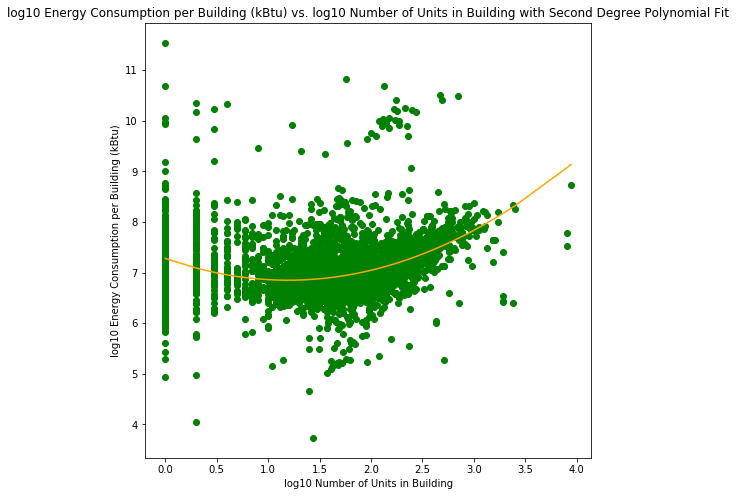

In [45]:
# plot
plt.figure(figsize=(8,8))
plt.plot(bblnrgdata_trunc['logunits'],bblnrgdata_trunc['lognrg'],'go')
plt.plot(bblnrgdata_trunc['logunits'], OLS_2nd_deg.predict(bblnrgdata_trunc),'-', color='orange')
plt.xlabel('log10 Number of Units in Building')
plt.ylabel('log10 Energy Consumption per Building (kBtu)')
plt.title('log10 Energy Consumption per Building (kBtu) vs. log10 Number of Units in Building with Second ' +
          'Degree Polynomial Fit', fontsize=12)

Figure 9: Energy consumption per building (kBtu) vs. Number of units in building in log10 scale plotted with a second degree polynomial model fit to the data. R-squared is 0.145 and log-likelihood is -3468.5 for the model. These values are improvements from the first degree linear model (r-squared = 0.018 and log-likelihood = -3815.3) which indicates that the second degree polynomial model fits the data better than the first degree polynomial model. 

In [46]:
# units as dependent and energy as independent 
# create a new feature for x^2
bblnrgdata_trunc['lognrg_sq'] = bblnrgdata_trunc['lognrg']**2

In [47]:
# fit a model to the data 
OLS_2nd_deg_units = smf.ols(formula='logunits ~ lognrg_sq + lognrg',data=bblnrgdata_trunc).fit()
OLS_2nd_deg_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     94.94
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           3.42e-41
Time:                        19:41:48   Log-Likelihood:                -4980.6
No. Observations:                4977   AIC:                             9967.
Df Residuals:                    4974   BIC:                             9987.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.5540      0.622     -8.933      0.000        -6.773    -4.335
lognrg_sq     -0.1084      0.011     -9.919      0.000        -0.130    -0.087
lognrg         1.7950      0.165     10.892      0.000         1.472     2.118
==============================================================================
Omnibus:                      839.579   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1360.626
Skew:                          -1.147   Prob(JB):                    3.50e-296
Kurtosis:                       4.140   Cond. No.                     3.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# sort the data for plotting
bblnrgdata_trunc.sort_values(by='lognrg', inplace=True)

Text(0.5,1,'log10 Number of Units in Building vs. log10 Energy Consumption per Building (kBtu) with Second Degree Polynomial Fit')

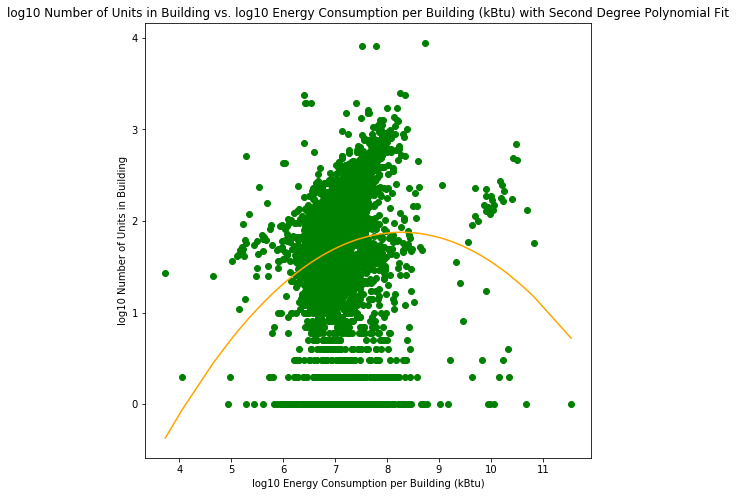

In [49]:
# plot
plt.figure(figsize=(8,8))
plt.plot(bblnrgdata_trunc['lognrg'],bblnrgdata_trunc['logunits'],'go')
plt.plot(bblnrgdata_trunc['lognrg'], OLS_2nd_deg_units.predict(bblnrgdata_trunc),'-', color='orange')
plt.ylabel('log10 Number of Units in Building')
plt.xlabel('log10 Energy Consumption per Building (kBtu)')
plt.title('log10 Number of Units in Building vs. log10 Energy Consumption per Building (kBtu) with Second ' +
          'Degree Polynomial Fit', fontsize=12)

Figure 10: log10 Number of units in building vs. log10 Energy consumption per building (kBtu) plotted with a second degree polynomial model fit to the data. R-squared is 0.037 and log-likelihood is -4980.6 for the model. These values are slight improvements from the first degree linear model (r-squared = 0.018 and log-likelihood = -5029.3) which indicates that the second degree polynomial model fits the data better than the first degree polynomial model. However, the model still does not fit the data well, and I previously stated that units should be the independent variable and energy should be the dependent variable. 

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [50]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones(len(data))
    
    chisq = ((data - model)**2 / errors**2).sum()
    return chisq

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [51]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

# calculate error on two measured quantities
bblnrgdata_trunc['error_area'] = np.sqrt(bblnrgdata_trunc['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdata_trunc['error_energy'] = np.sqrt(bblnrgdata_trunc['Site EUI(kBtu/ft2)'])

# nrg is product of area and energy per sq ft --> errors propogate  
bblnrgdata_trunc['error_nrg'] = np.sqrt(bblnrgdata_trunc['error_area']**2 + bblnrgdata_trunc['error_energy']**2)

# propagation of errors on the log (from formula above) for nrg 
bblnrgdata_trunc['error_log_nrg'] = bblnrgdata_trunc['error_nrg'] / (bblnrgdata_trunc['nrg'] * np.log(10))

# propagation of errors on the log (from formula above) for units 
bblnrgdata_trunc['error_units'] = np.sqrt(bblnrgdata_trunc['UnitsTotal'])

bblnrgdata_trunc['error_log_units'] = bblnrgdata_trunc['error_units'] / (bblnrgdata_trunc['UnitsTotal'] 
                                                                         * np.log(10))

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

(5, 11)

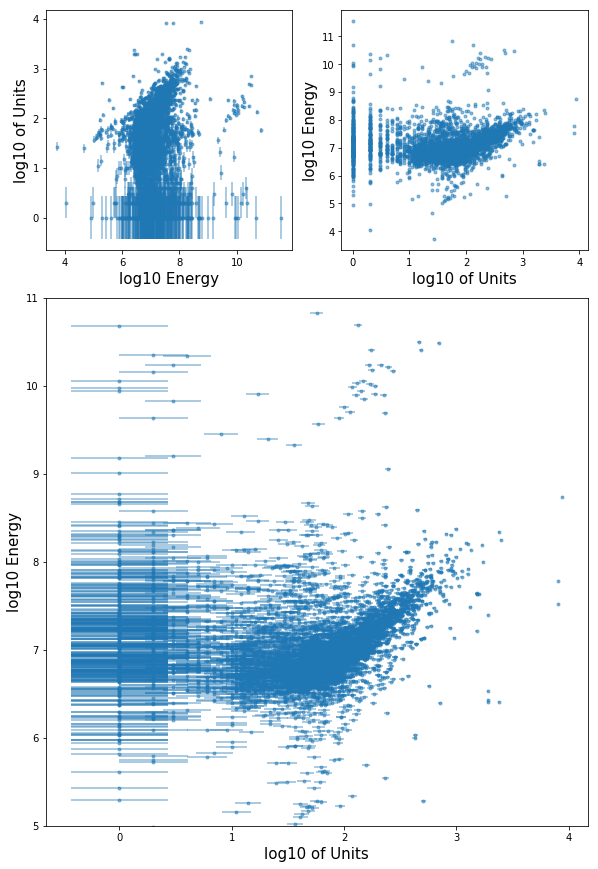

In [52]:
#I could also include errors for number of units
fig2 = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(bblnrgdata_trunc.lognrg, bblnrgdata_trunc.logunits, yerr=bblnrgdata_trunc.error_log_units, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(bblnrgdata_trunc.logunits, bblnrgdata_trunc.lognrg, yerr=bblnrgdata_trunc.error_log_nrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(bblnrgdata_trunc.logunits, bblnrgdata_trunc.lognrg, yerr=bblnrgdata_trunc.error_log_nrg,
           xerr=bblnrgdata_trunc.error_log_units, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

Figure 11: The same as Figure 9 and 10, but with errorbars. In the top left panel the errors on the Units in the building are plotted, in the top right panels the errors on the energy are plotted, but they are too small to see,  and both in the bottom panel. The bottom panel is a zoom-in of the top right panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the energy consumption is a continuous variable, only discretized by the act of measuring it. 

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [53]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdata_trunc) - 1
print ("degrees of freedom:" , dof)

degrees of freedom: 4976


In [54]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.UnitsTotal), u_vs_e.predict()) / float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.UnitsTotal), u_vs_e.predict(), 
            errors = bblnrgdata_trunc.error_log_nrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.UnitsTotal), u_vs_e.predict(), 
            errors = np.sqrt(bblnrgdata_trunc.error_log_nrg**2 + 
                             bblnrgdata_trunc.error_log_units**2))  / dof))

Units vs Energy residuals (no errors include): 0.45
Units vs Energy chi square per DOF w independent variable error only: 177913967397261.47
Units vs Energy chi square per DOF : 471.63


In [55]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.nrg), e_vs_u.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.nrg), e_vs_u.predict(), 
            errors = bblnrgdata_trunc.error_log_nrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata_trunc.nrg), e_vs_u.predict(), 
            errors = np.sqrt(bblnrgdata_trunc.error_log_nrg**2 + 
                             bblnrgdata_trunc.error_log_units**2))  / dof))


Energy vs Units residuals (no errors include): 0.28
Energy vs Units chi square per DOF w independent variable error only: 1213562174872929.50
Energy vs Units chi square per DOF : 247.92


### Compare the models using the  chi square:
The chi-square per DOF for energy vs. units is 198.85. The chi-square per DOF for units vs. energy is 417.21. Since chi-square is smaller for energy vs. units than for units vs. energy, energy vs. units fits the data better. The larger the chi-square, the worse your model since it is essentially a measure of the squared residuals. 

## influence plots ##

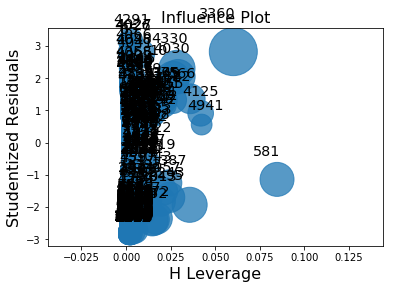

In [56]:
# plot influence plot - units vs. energy
sm.graphics.influence_plot(OLS_2nd_deg_units, alpha  = 0.05, criterion="cooks");

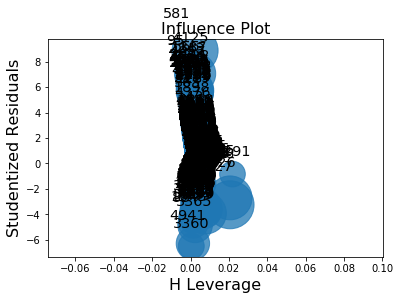

In [57]:
# plot influence plot - energy vs. units
sm.graphics.influence_plot(OLS_2nd_deg, alpha  = 0.05, criterion="cooks");

Figure 12: The top plot is an influence plot of units vs. energy and the second plot is an influence plot of energy vs. units. The axis values on the second plot (energy vs. units) are an order of magnitude larger than the axis values on the first plot (units vs. energy). The distribution of points along the exogenous variable is much better suited to a line fit in the energy vs. units plot than the units vs. energy plot. I want a large spread in the exogenous variable. In the units vs. energy plot, most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for these points. The core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [58]:
# calculate the likelihood ratio for the linear and curve fit 
OLS_2nd_deg.compare_lr_test(e_vs_u)

(693.44568768132103, 7.961446169126647e-153, 1.0)

## chi square table ##

![chi sq table](chisq.gif)

The p value = 8e-153 and the likelihood ratio = 693.4. Since the p value < the alpha I set at 0.05 I reject the null hypothesis that the simpler model is preferable. The likelihood ratio is chi square distributed and has a value of 693.4. The value in the chi square table above for alpha = 0.05 and 1 degree of freedom is 3.841. Since my calculated chi square is greater than 3.841, this also indicates that I should reject the null hypothesis that the simpler model is preferable. This makes sense because the quadratic model appears to fit the energy vs. units data better in the plots above. 

# EXTRA CREDIT: a plot of anything related to these data

In [59]:
# calculate log of area
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])

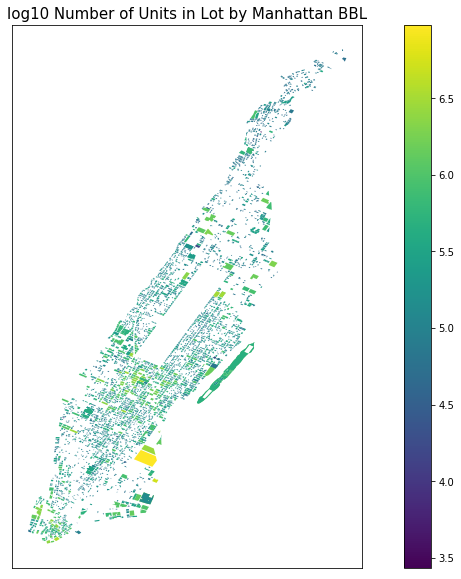

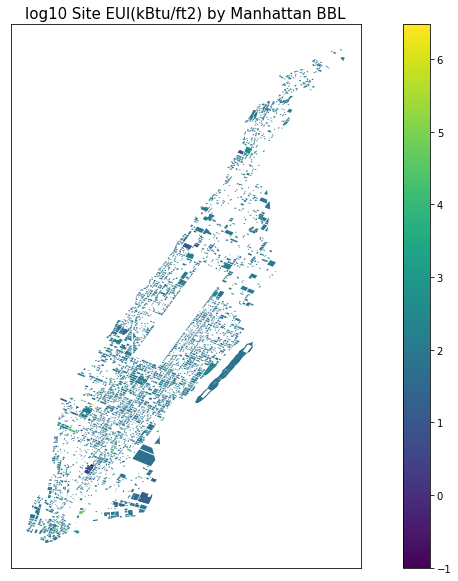

In [60]:
# plot a chropleth of log10(area) and log10(energy consumed)
f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='logarea',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("log10 Number of Units in Lot by Manhattan BBL", fontsize=15)
ax.set_aspect(.75)

f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='lognrg',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("log10 Site EUI(kBtu/ft2) by Manhattan BBL", fontsize=15)
ax.set_aspect(.75)

Figure 13: The top plot is a choropleth of log10 Area of building by Manhattan Borough Block Lot and the bottom plot is a choropleth of log10 Site EUI(kBtu/ft2) by Manhattan Borough Block Lot. Yellow/green lots indicate higher area or higher energy for the two plots respectively. Blue/purple lots indicate lower area or lower energy for the two plots respectively. I converted area and energy consumed to log10 scale because the data is distributed very “unevenly”. In the natural scale, most observations have low energy and low number of units. For energy, there are a few values in the scale of 10^6 or 10^7 and a few as high as 10^9. In the log10 scale, this becomes a 6 to 9 range. There is an outlier in the area plot in the east village in Manhattan. This is the Con Edison power plant which has a large building area. In the energy choropleth, I don't see any outliers that stand out. The shade of the choropleth is relatively uniform, with most BBLs in the 1 to 3 range for energy consumption.

Text(0,0.5,'Area of Building')

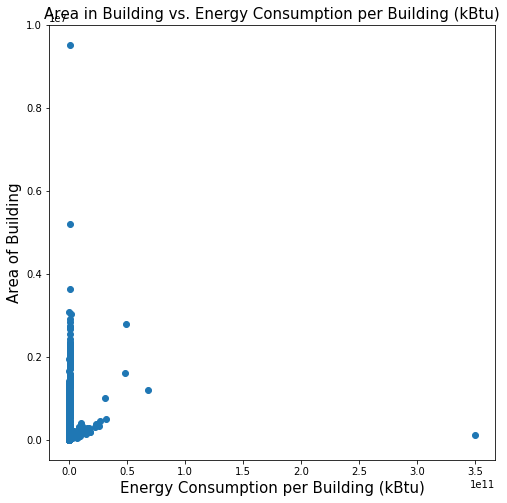

In [61]:
## plot area vs. energy per building 
figure = plt.figure(figsize=(8,8))
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
plt.scatter(bblnrgdata.nrg, bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'])
plt.title('Area in Building vs. Energy Consumption per Building (kBtu)', fontsize=15)
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=15)
plt.ylabel('Area of Building', fontsize=15)

In [62]:
# remove outliers
bblnrgdata_new = bblnrgdata.drop(bblnrgdata[(bblnrgdata.nrg < 1000) & (bblnrgdata.nrg > 1e10) &
                                 (bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] 
                                < 1) & (bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] > 9000)].index)

Text(0,0.5,'Area of Building')

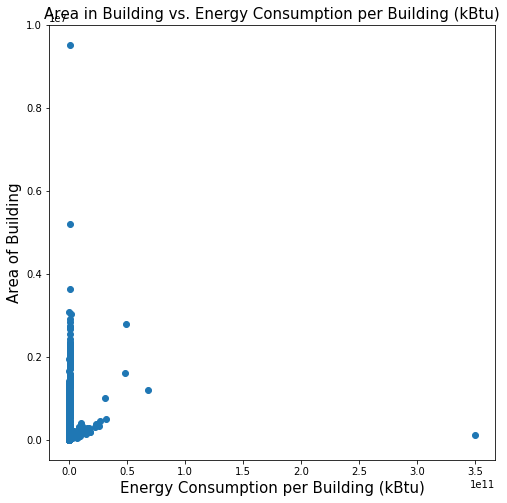

In [63]:
## plot area vs. energy per building 
figure = plt.figure(figsize=(8,8))
plt.scatter(bblnrgdata_new.nrg, bblnrgdata_new['Reported Property Floor Area (Building(s)) (ft²)'])
plt.title('Area in Building vs. Energy Consumption per Building (kBtu)', fontsize=15)
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=15)
plt.ylabel('Area of Building', fontsize=15)

Figure 14: Scatterplot of area of building vs. energy consumption per building. The first plot above is difficult to interpret because I'm unable to see most points due to outliers in the plot. The second plot above is zoomed in. I see that there are a lot of points along the y axis with very low levels of energy consumption. There appears to be a positive linear relationship between area of building and energy consumption per building for the group of points in the lower left area of the scatterplot. 